In [2]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb


import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras import regularizers as R
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import optimizers as O
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [3]:
train_feats = pd.read_csv('../../3_feature_eng/output/train_feats_double_corr.csv')
train_score = pd.read_csv('../../0_data/train_scores.csv')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_feats['score'])

score_transformed = le.transform(train_feats['score'])

## Keep columns

In [4]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft", "avg_event_per_minute",
# "avg_char_deletion_per_minute", "avg_char_insert_per_minute"
# "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies"
# "IWD", "idle", "cursor_visits"
# "intro_punctuation", "body_punctuation", "conclusion_punctuation"
# "intro_aggs", "body_aggs", "conclusion_aggs", "IKI_actual"
# "bursts_v2"

endings_to_keep = ["-count_bursts", "-word_sent_parag_agg", "intro_punctuation", "body_punctuation", "conclusion_punctuation",
 "intro_aggs", "body_aggs", "conclusion_aggs", "cursor_visits", "IWD"]
endings_to_keep += ["id"]
    
dir_to_save = "dnn1"
try:
    os.mkdir(dir_to_save)
except:
    print('Already exists')
    sys.exit()

cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]

with open(f'{dir_to_save}/feature_list.pkl', 'wb') as f:
    pickle.dump(cols_to_keep, f)

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

408


In [6]:
counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [7]:
with open(f'{dir_to_save}/new_col_dict.pkl', 'wb') as f:
    pickle.dump(new_columns, f)

In [8]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

## Architecture

In [9]:
@tf.keras.utils.register_keras_serializable()
def smish(x):
    return x * K.tanh(K.log(1 + K.sigmoid(x)))

@tf.keras.utils.register_keras_serializable()
class GatedLinearUnit(L.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.linear = L.Dense(units)
        self.sigmoid = L.Dense(units, activation="sigmoid")
        self.units = units

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        return config
    
    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)
    

@tf.keras.utils.register_keras_serializable()
class GatedResidualNetwork(L.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.relu_dense = L.Dense(units, activation=smish)
        self.linear_dense = L.Dense(units)
        self.dropout = L.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = L.LayerNormalization()
        self.project = L.Dense(units)

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config
    
    def call(self, inputs):
        x = self.relu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x
    

@tf.keras.utils.register_keras_serializable()
class VariableSelection(L.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.grns = list()
        # Create a GRN for each feature independently
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = L.Dense(units=num_features, activation="softmax")
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate

    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config
    
    def call(self, inputs):
        v = L.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input_ in enumerate(inputs):
            x.append(self.grns[idx](input_))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs
    

@tf.keras.utils.register_keras_serializable()
class VariableSelectionFlow(L.Layer):
    def __init__(self, num_features, units, dropout_rate, dense_units=None, **kwargs):
        super().__init__(**kwargs)
        self.variableselection = VariableSelection(num_features, units, dropout_rate)
        self.split = L.Lambda(lambda t: tf.split(t, num_features, axis=-1))
        self.dense = dense_units
        if dense_units:
            self.dense_list = [L.Dense(dense_units, \
                                       activation='linear') \
                               for _ in tf.range(num_features)
                              ]
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate
        self.dense_units = dense_units
        
    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        config['dense_units'] = self.dense_units
        return config        
    
    def call(self, inputs):
        split_input = self.split(inputs)
        if self.dense:
            l = [self.dense_list[i](split_input[i]) for i in range(len(self.dense_list))]
        else:
            l = split_input
        return self.variableselection(l)

In [10]:
# Define RMSE loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Define MSE loss function
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [11]:
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps):
        super(LRSchedule, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        warmup_factor = tf.minimum(1.0, step / self.warmup_steps)
        return self.initial_learning_rate * warmup_factor

    def reduce_lr(self, factor):
        self.initial_learning_rate *= factor

In [12]:
def train_loop(train_dataset, val_dataset, x_val2, iter, split, val_split, batch_size):

    dense_units = 4

    units_1 = 32
    drop_1 = 0.5

    units_2 = 16
    drop_2 = 0.4

    units_3 = 8
    drop_3 = 0.3

    num_features = len(train_cols)

    # Define the input shape
    input_shape = (num_features,)

    # Define the model
    inputs = tf.keras.Input(shape=input_shape)
    feat_1 = VariableSelectionFlow(num_features, units_1, drop_1, dense_units)(inputs)
    feat_2 = VariableSelectionFlow(units_1, units_2, drop_2, dense_units)(feat_1)
    feat_3 = VariableSelectionFlow(units_2, units_3, drop_3, dense_units)(feat_2)
    outputs = tf.keras.layers.Dense(1, activation=lambda x: 6.0 * tf.sigmoid(x))(feat_3)  # for regression, the final layer has 1 unit
    model = Model(inputs=inputs, outputs=outputs)

    # Define the optimizer with a linear warmup
    warmup_steps = len(train_feats[train_cols]) // batch_size  # number of steps in one epoch
    learning_rate = LRSchedule(1e-4, warmup_steps)
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Define the loss function
    loss_fn = tf.keras.losses.MeanSquaredError()

    epochs = 100
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 1
    factor = 0.95

    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}')
        
        # Training loop
        train_loss = 0
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Forward pass
                y_pred = model(x_batch, training=True)
                # Compute the loss value
                loss_value = loss_fn(y_batch, y_pred)

            # Compute gradients
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Update weights
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            train_loss += loss_value

        print(f'Training loss(mse): {float(train_loss/step+1)}')
        
        # Validation loop
        val_loss = []
        for x_batch_val, y_batch_val in val_dataset:
            y_val_pred = model(x_batch_val, training=False)
            val_loss_value = root_mean_squared_error(y_batch_val.numpy(), y_val_pred)
            val_loss.append(val_loss_value)
        
        mean_val_loss = np.mean(val_loss)
        print(f'Validation rmse: {mean_val_loss}')

        # Check for early stopping
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            model.save(f'{dir_to_save}/model_iter{iter}_split{split}_val{val_split}.h5')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                old_lr = float(optimizer.learning_rate(optimizer.iterations))
                optimizer.learning_rate.reduce_lr(factor)
                new_lr = float(optimizer.learning_rate(optimizer.iterations))
                print(f'Reducing learning rate from {old_lr} to {new_lr}.')
            if epochs_no_improve == 10:
                print('Early stopping!')
                break

    # Load best model
    model.load_weights(f'{dir_to_save}/model_iter{iter}_split{split}_val{val_split}.h5')
    val_preds = model.predict(x_val2)

    return val_preds

In [13]:
def dnn_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42):

    # Noise
    y_train = y_train + np.random.normal(0, 0.1, y_train.shape)

    # Fill na with median
    x_train = x_train.fillna(x_train.median())
    x_valid = x_valid.fillna(x_train.median())

    x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

    batch_size = 64

    '''Use v1, test on v2'''
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
    val_dataset_1 = tf.data.Dataset.from_tensor_slices((x_valid1, y_valid1)).batch(batch_size)
    val_dataset_2 = tf.data.Dataset.from_tensor_slices((x_valid2, y_valid2)).batch(batch_size)

    # Predict on v2
    valid2_predict = train_loop(train_dataset, val_dataset_1, x_valid2, iter, split, val_split='1', batch_size=batch_size)

    # Predict on v1
    valid1_predict = train_loop(train_dataset, val_dataset_2, x_valid1, iter, split, val_split='2', batch_size=batch_size)

    # Return OOFs
    return np.concatenate([valid1_predict,valid2_predict])

In [14]:
OOF_SCORE = np.zeros(len(train_feats))

iterations = 3
n_splits = 4

for i in range(iterations):

    kf = model_selection.StratifiedKFold(n_splits=n_splits, random_state=41, shuffle=True)
    j = 0
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats, score_transformed)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

        valid_predict = dnn_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41)
        OOF_SCORE[valid_idx] += valid_predict.flatten() / iterations
        j+=1

Starting epoch 1
Training loss(mse): 2.420448064804077
Validation rmse: 1.0195341110229492
Starting epoch 2
Training loss(mse): 2.0301647186279297
Validation rmse: 0.9058881998062134
Starting epoch 3
Training loss(mse): 1.8368005752563477
Validation rmse: 0.8037346601486206
Starting epoch 4
Training loss(mse): 1.6859478950500488
Validation rmse: 0.7349337339401245
Starting epoch 5
Training loss(mse): 1.6699397563934326
Validation rmse: 0.7225576639175415
Starting epoch 6
Training loss(mse): 1.6133826971054077
Validation rmse: 0.7204931378364563
Starting epoch 7
Training loss(mse): 1.6138721704483032
Validation rmse: 0.74403315782547
Reducing learning rate from 0.0001 to 9.5e-05.
Starting epoch 8
Training loss(mse): 1.6040034294128418
Validation rmse: 0.7147997617721558
Starting epoch 9
Training loss(mse): 1.571548342704773
Validation rmse: 0.7105284929275513
Starting epoch 10
Training loss(mse): 1.587795615196228
Validation rmse: 0.7225536704063416
Reducing learning rate from 9.5e-05 t

KeyboardInterrupt: 

In [ ]:
print('OOF metric DNN = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_SCORE,
                                                                   squared=False)))

OOF metric = 3.33049


In [ ]:
import pickle

with open(f'{dir_to_save}/OOF_base_dnn.pkl', 'wb') as f:
    pickle.dump(OOF_SCORE, f)

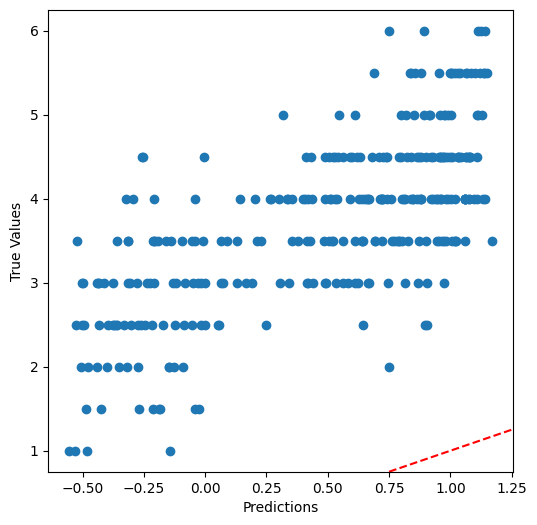

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(OOF_SCORE, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()